### Импорт библиотек и загрузка данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('insurance.csv')
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика:")
print(df.describe())

Размер данных: (1338, 7)

Первые 5 строк:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Статистика:
              

### Корреляционный анализ с charges

Корреляционная матрица (Pearson):
charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

Сравнение коэффициентов корреляции с charges:

age:
  Pearson: r=0.2990, p=0.0000
  Spearman: ρ=0.5344, p=0.0000
  Kendall: τ=0.4753, p=0.0000

bmi:
  Pearson: r=0.1983, p=0.0000
  Spearman: ρ=0.1194, p=0.0000
  Kendall: τ=0.0825, p=0.0000

children:
  Pearson: r=0.0680, p=0.0129
  Spearman: ρ=0.1333, p=0.0000
  Kendall: τ=0.1031, p=0.0000

Топ-3 переменные по |r| Pearson: ['age', 'bmi', 'children']


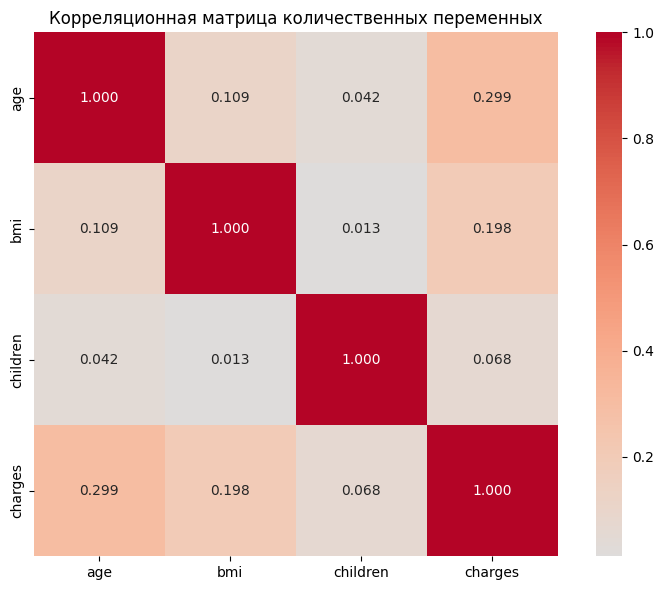

In [5]:
# Количественные переменные
numeric_cols = ['age', 'bmi', 'children', 'charges']
corr_matrix = df[numeric_cols].corr(method='pearson')
print("Корреляционная матрица (Pearson):")
print(corr_matrix['charges'].sort_values(ascending=False))

# Различные коэффициенты корреляции для количественных переменных с charges
print("\nСравнение коэффициентов корреляции с charges:")
correlations = {}
for col in ['age', 'bmi', 'children']:
    pearson_corr, pearson_p = pearsonr(df[col], df['charges'])
    spearman_corr, spearman_p = spearmanr(df[col], df['charges'])
    kendall_corr, kendall_p = kendalltau(df[col], df['charges'])
    
    correlations[col] = {
        'Pearson': (pearson_corr, pearson_p),
        'Spearman': (spearman_corr, spearman_p),
        'Kendall': (kendall_corr, kendall_p)
    }
    
    print(f"\n{col}:")
    print(f"  Pearson: r={pearson_corr:.4f}, p={pearson_p:.4f}")
    print(f"  Spearman: ρ={spearman_corr:.4f}, p={spearman_p:.4f}")
    print(f"  Kendall: τ={kendall_corr:.4f}, p={kendall_p:.4f}")

# Топ-3 переменные по корреляции (Pearson)
top_corr = corr_matrix['charges'].abs().sort_values(ascending=False)
print(f"\nТоп-3 переменные по |r| Pearson: {top_corr[1:4].index.tolist()}")

# Визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Корреляционная матрица количественных переменных')
plt.tight_layout()
plt.show()

### Корреляция между sex и smoker

Таблица сопряженности sex × smoker:
smoker   no  yes
sex             
female  547  115
male    517  159

Тест хи-квадрат:
χ² = 7.3929, p-value = 0.0065, степени свободы = 1
Коэффициент phi = 0.0743


<Figure size 800x600 with 0 Axes>

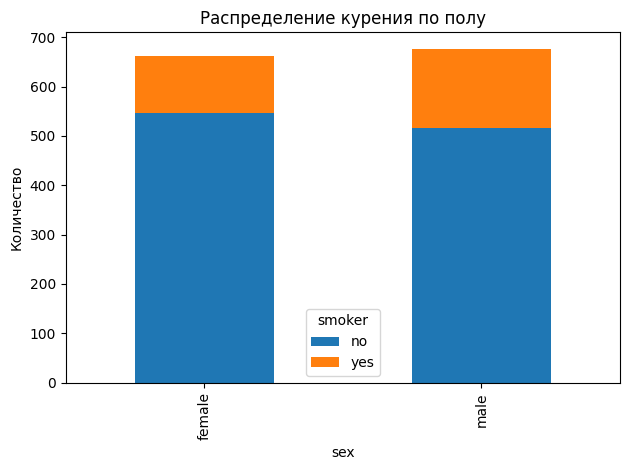

In [6]:
# Кодирование категориальных переменных
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker'], dtype=int)

# Таблица сопряженности
contingency_table = pd.crosstab(df['sex'], df['smoker'])
print("Таблица сопряженности sex × smoker:")
print(contingency_table)

# Тест хи-квадрат
chi2, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nТест хи-квадрат:")
print(f"χ² = {chi2:.4f}, p-value = {chi2_p:.4f}, степени свободы = {dof}")

# Коэффициент phi
phi = np.sqrt(chi2 / contingency_table.sum().sum())
print(f"Коэффициент phi = {phi:.4f}")

# Визуализация
plt.figure(figsize=(8, 6))
contingency_table.plot(kind='bar', stacked=True)
plt.title('Распределение курения по полу')
plt.ylabel('Количество')
plt.legend(title='smoker')
plt.tight_layout()
plt.show()


### Однофакторный дисперсионный анализ

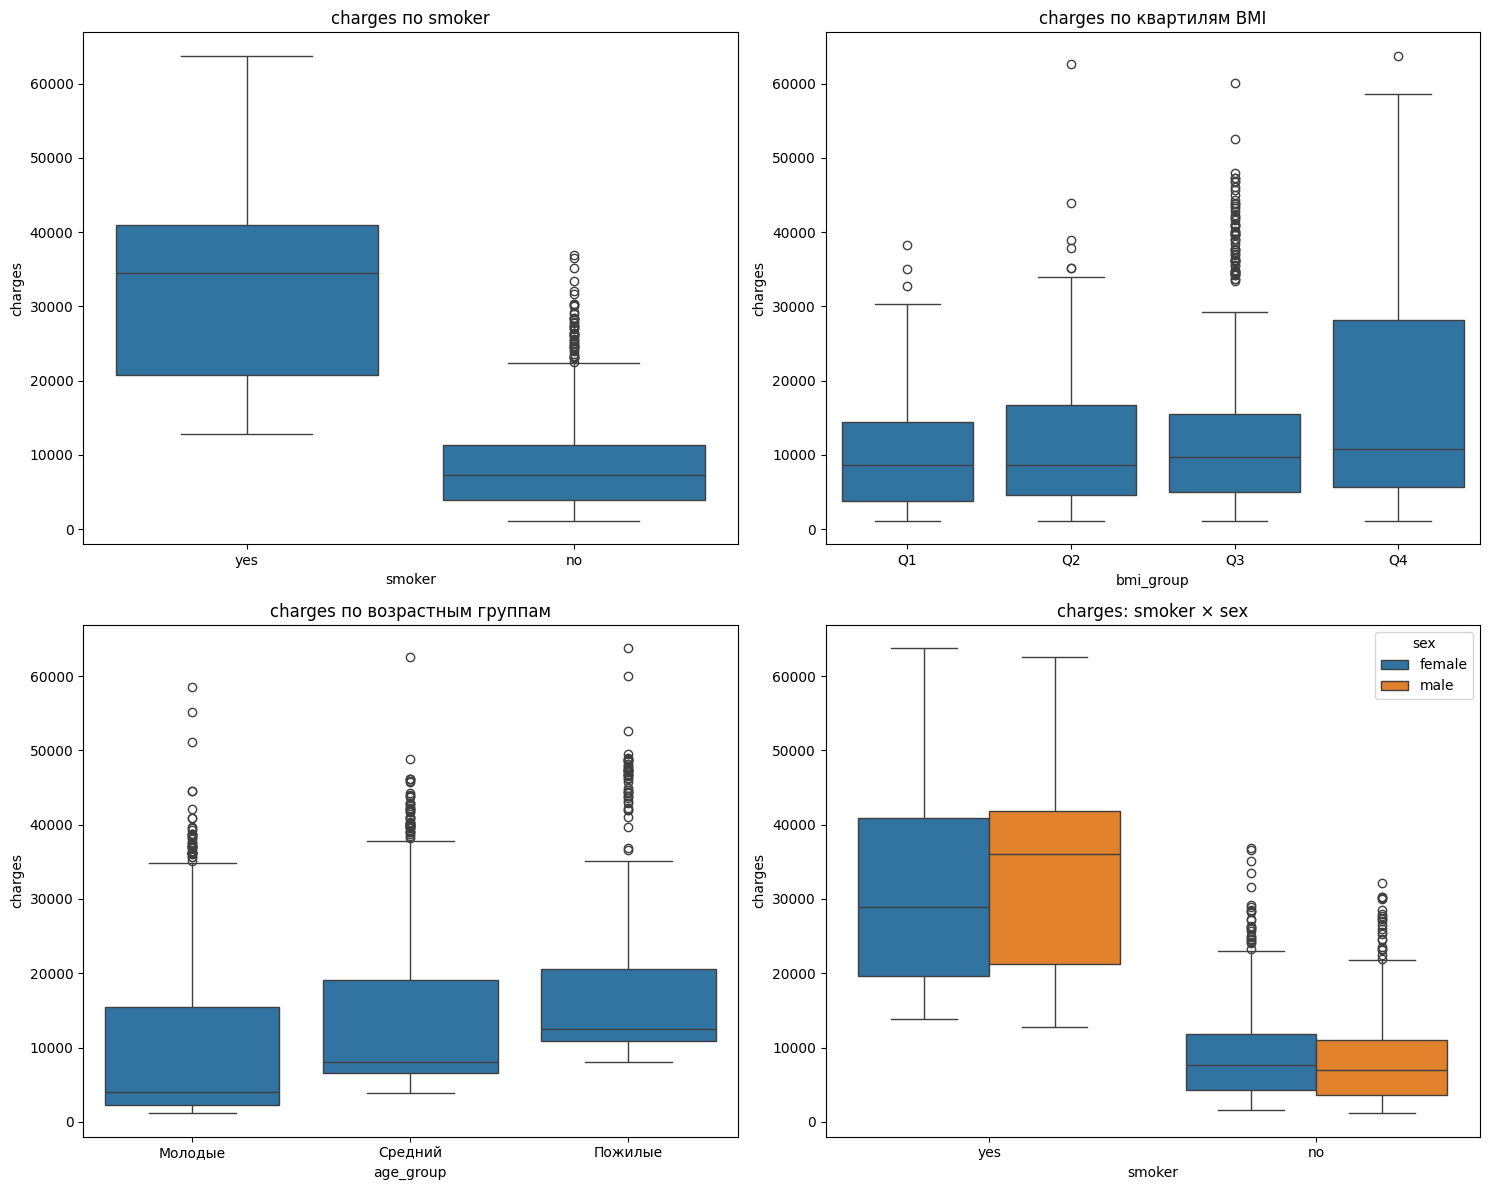

Однофакторный ANOVA:
1. Курение: F=2177.6149, p=0.0000
2. BMI (квартили): F=21.4650, p=0.0000
3. Возраст (3 группы): F=54.3570, p=0.0000

Проверка нормальности остатков (Shapiro-Wilk):
smoker группа 0: W=0.8729, p=0.0000
smoker группа 1: W=0.9396, p=0.0000
bmi_group группа 0: W=0.9076, p=0.0000
bmi_group группа 1: W=0.8661, p=0.0000
bmi_group группа 2: W=0.7970, p=0.0000
bmi_group группа 3: W=0.8117, p=0.0000
age_group группа 0: W=0.6984, p=0.0000
age_group группа 1: W=0.6981, p=0.0000
age_group группа 2: W=0.6946, p=0.0000


In [7]:
# Boxplot для визуализации
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Курение
sns.boxplot(data=df, x='smoker', y='charges', ax=axes[0,0])
axes[0,0].set_title('charges по smoker')

# BMI (разделим на квартили)
df['bmi_group'] = pd.qcut(df['bmi'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
sns.boxplot(data=df, x='bmi_group', y='charges', ax=axes[0,1])
axes[0,1].set_title('charges по квартилям BMI')

# Возраст (3 категории)
df['age_group'] = pd.cut(df['age'], 3, labels=['Молодые', 'Средний', 'Пожилые'])
sns.boxplot(data=df, x='age_group', y='charges', ax=axes[1,0])
axes[1,0].set_title('charges по возрастным группам')

# Все факторы вместе
sns.boxplot(data=df, x='smoker', y='charges', hue='sex', ax=axes[1,1])
axes[1,1].set_title('charges: smoker × sex')

plt.tight_layout()
plt.show()

# ANOVA тесты
print("Однофакторный ANOVA:")

# 1. Курение
smoker_f, smoker_p = stats.f_oneway(
    df[df['smoker']=='yes']['charges'],
    df[df['smoker']=='no']['charges']
)
print(f"1. Курение: F={smoker_f:.4f}, p={smoker_p:.4f}")

# 2. BMI группы
bmi_f, bmi_p = stats.f_oneway(
    df[df['bmi_group']=='Q1']['charges'],
    df[df['bmi_group']=='Q2']['charges'],
    df[df['bmi_group']=='Q3']['charges'],
    df[df['bmi_group']=='Q4']['charges']
)
print(f"2. BMI (квартили): F={bmi_f:.4f}, p={bmi_p:.4f}")

# 3. Возрастные группы
age_f, age_p = stats.f_oneway(
    df[df['age_group']=='Молодые']['charges'],
    df[df['age_group']=='Средний']['charges'],
    df[df['age_group']=='Пожилые']['charges']
)
print(f"3. Возраст (3 группы): F={age_f:.4f}, p={age_p:.4f}")

# Проверка нормальности (Shapiro-Wilk для групп)
print("\nПроверка нормальности остатков (Shapiro-Wilk):")
for group_col in ['smoker', 'bmi_group', 'age_group']:
    groups = [group['charges'].values for name, group in df.groupby(group_col)]
    for i, group in enumerate(groups):
        if len(group) >= 3 and len(group) <= 5000:  # ограничения Shapiro-Wilk
            stat, p = stats.shapiro(group)
            print(f"{group_col} группа {i}: W={stat:.4f}, p={p:.4f}")


### 4. Двухфакторный дисперсионный анализ

Двухфакторный ANOVA (smoker × sex):
                        sum_sq      df            F         PR(>F)
C(smoker)         1.208777e+11     1.0  2177.284440  1.247285e-282
C(sex)            1.421312e+06     1.0     0.025601   8.729026e-01
C(smoker):C(sex)  4.923397e+08     1.0     8.868165   2.954255e-03
Residual          7.406056e+10  1334.0          NaN            NaN

Интерпретация:
✓ Основный эффект курения значим
✗ Основный эффект пола не значим
✓ Взаимодействие smoker×sex значимо (разный эффект!)


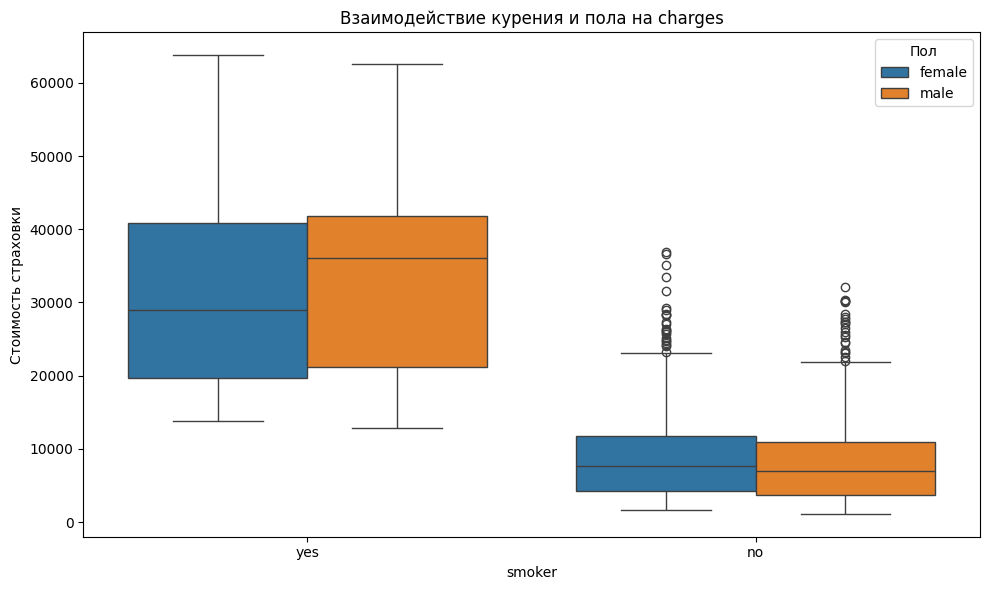

In [8]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Двухфакторный ANOVA: smoker × sex
model = ols('charges ~ C(smoker) * C(sex)', data=df).fit()
anova_results = anova_lm(model, typ=2)

print("Двухфакторный ANOVA (smoker × sex):")
print(anova_results)

# Интерпретация
print("\nИнтерпретация:")
if anova_results['PR(>F)']['C(smoker)'] < 0.05:
    print("✓ Основный эффект курения значим")
else:
    print("✗ Основный эффект курения не значим")

if anova_results['PR(>F)']['C(sex)'] < 0.05:
    print("✓ Основный эффект пола значим")
else:
    print("✗ Основный эффект пола не значим")

if anova_results['PR(>F)']['C(smoker):C(sex)'] < 0.05:
    print("✓ Взаимодействие smoker×sex значимо (разный эффект!)")
else:
    print("✗ Взаимодействие smoker×sex не значимо")

# Визуализация взаимодействия
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='smoker', y='charges', hue='sex')
plt.title('Взаимодействие курения и пола на charges')
plt.ylabel('Стоимость страховки')
plt.legend(title='Пол')
plt.tight_layout()
plt.show()
